In [1]:
import pandas as pd
from feature_creation import data_copy
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from os import cpu_count
import numpy as np
import seaborn as sns

In [2]:
data_copy['increase_stock'] = data_copy['increase_stock'].apply(lambda entity: 1 if entity == 'high_bike_demand' else 0)
data_copy['increase_stock'] = data_copy['increase_stock'].astype('int')
data_copy.describe()

,holiday,weekday,summertime,temp,dew,humidity,precip,snowdepth,windspeed,cloudcover,visibility,increase_stock,daytime,rushhour,weather_score,weather_score_daytime
count,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.033125,0.710000,0.64375,15.210313,7.750750,63.927844,0.122042,0.042713,13.082500,64.322375,15.344125,0.180000,0.543750,0.205625,0.180000,0.127378
std,0.179019,0.453904,0.47904,9.264785,10.026459,19.079419,0.920600,0.421198,7.756652,32.748869,2.323737,0.384308,0.498238,0.404284,0.184322,0.189459
min,0.000000,0.000000,0.00000,-9.100000,-18.400000,15.850000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,-0.239787,-0.160192
25%,0.000000,0.000000,0.00000,7.700000,-0.800000,47.845000,0.000000,0.000000,7.500000,28.800000,16.000000,0.000000,0.000000,0.000000,0.049945,0.000000
50%,0.000000,1.000000,1.00000,15.500000,8.300000,65.175000,0.000000,0.000000,12.300000,79.300000,16.000000,0.000000,1.000000,0.000000,0.154343,0.000000
75%,0.000000,1.000000,1.00000,23.200000,16.800000,79.955000,0.000000,0.000000,17.600000,92.800000,16.000000,0.000000,1.000000,0.000000,0.278779,0.225751
max,1.000000,1.000000,1.00000,35.600000,24.300000,99.890000,25.871000,6.710000,43.800000,100.000000,16.000000,1.000000,1.000000,1.000000,0.956538,0.956538


In [3]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   hour_of_day            1600 non-null   category
 1   day_of_week            1600 non-null   category
 2   month                  1600 non-null   category
 3   holiday                1600 non-null   int64   
 4   weekday                1600 non-null   int64   
 5   summertime             1600 non-null   int64   
 6   temp                   1600 non-null   float64 
 7   dew                    1600 non-null   float64 
 8   humidity               1600 non-null   float64 
 9   precip                 1600 non-null   float64 
 10  snowdepth              1600 non-null   float64 
 11  windspeed              1600 non-null   float64 
 12  cloudcover             1600 non-null   float64 
 13  visibility             1600 non-null   float64 
 14  increase_stock         1600 non-null   i

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_copy.drop('increase_stock',axis=1), data_copy['increase_stock'], test_size=0.1, random_state=123) 

preprocessor = ColumnTransformer([('cat',OneHotEncoder(), list(X_train.select_dtypes(include='category').columns)),
                                  ('stand', Normalizer(), list(X_train.columns))],
                                 remainder='passthrough')
logreg_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1',C=.2,solver='liblinear',max_iter=10000))
])

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)
cross_val_results = cross_val_score(logreg_model, X_train, y_train, cv=kf, scoring='accuracy',n_jobs=cpu_count()) #run in parallel

# Print the cross-validation results
print(f'Cross-validation results: {cross_val_results}')
print(f'Mean accuracy: {np.mean(cross_val_results)}')

Cross-validation results: [0.86805556 0.90625    0.90277778 0.88194444 0.80555556]
Mean accuracy: 0.8729166666666666


In [6]:
logreg_model.fit(X_train,y_train)
processed_names = logreg_model[:-1].get_feature_names_out()
logreg_coefs = logreg_model.named_steps["classifier"].coef_[0]
print(f'col len: {len(processed_names)} coef len: {len(logreg_coefs)}')
for item in zip(processed_names,logreg_coefs):
    print(f'{item[0]} = {item[1]}')

col len: 61 coef len: 61
cat__hour_of_day_0 = -2.057367310115534
cat__hour_of_day_1 = -1.921545907130418
cat__hour_of_day_2 = -1.3002154217536708
cat__hour_of_day_3 = -1.5208572887903322
cat__hour_of_day_4 = -1.8108086280082836
cat__hour_of_day_5 = -1.4377310928947524
cat__hour_of_day_6 = -1.2471836509064362
cat__hour_of_day_7 = -0.7412335169665676
cat__hour_of_day_8 = 0.885986037986444
cat__hour_of_day_9 = 0.22294880535449826
cat__hour_of_day_10 = 0.0
cat__hour_of_day_11 = 0.46195735715834524
cat__hour_of_day_12 = 0.6239506666856663
cat__hour_of_day_13 = 0.0
cat__hour_of_day_14 = 0.0905451912081838
cat__hour_of_day_15 = 1.2783182465145015
cat__hour_of_day_16 = 1.0630675838029136
cat__hour_of_day_17 = 1.893954709736247
cat__hour_of_day_18 = 2.528023571548708
cat__hour_of_day_19 = 1.4071058005039647
cat__hour_of_day_20 = -0.7826273262060724
cat__hour_of_day_21 = -2.380840123060924
cat__hour_of_day_22 = -1.4743879498242847
cat__hour_of_day_23 = -2.162863922198943
cat__day_of_week_0 = 0.0

### Now lets optimize the C (lambda) and see if we can improve the score

In [7]:
## NOTE! very expensive code. Uncomment for very long run time
# mean_cross_val_scores = []
# for i in range(1,100):
#     result = {}
#     C_temp = i/100
#     logreg_model = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', LogisticRegression(penalty='l1',C=C_temp,solver='liblinear',max_iter=10000))
#     ])
#     cvs = cross_val_score(logreg_model, X_train, y_train, cv=kf, scoring='accuracy',n_jobs=cpu_count()) #run in parallel
#     result['cvs'] = cvs
#     result['mean_perf'] = np.mean(cvs)
#     result['reg_val'] = C_temp
#     mean_cross_val_scores.append(result)
# performance_df = pd.DataFrame(mean_cross_val_scores)

<Axes: xlabel='reg_val'>

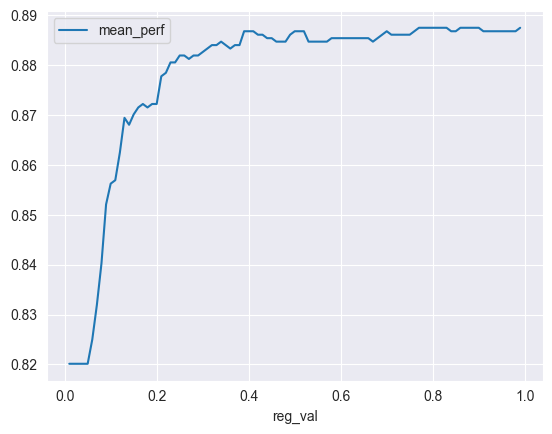

In [8]:
performance_df = pd.read_csv('../data/log_lasso_optimization.csv') # read file instead of running opt again
performance_df.plot(x='reg_val',y='mean_perf')

In [19]:
print(performance_df.loc[performance_df['mean_perf'].idxmax()])
print(performance_df.tail(10))

cvs          [1. 1. 1. ... 1. 0. 1.]
mean_perf                     0.8875
reg_val                         0.77
Name: 76, dtype: object
                        cvs  mean_perf  reg_val
89  [1. 1. 1. ... 1. 0. 1.]   0.887500     0.90
90  [1. 1. 1. ... 1. 0. 1.]   0.886806     0.91
91  [1. 1. 1. ... 1. 0. 1.]   0.886806     0.92
92  [1. 1. 1. ... 1. 0. 1.]   0.886806     0.93
93  [1. 1. 1. ... 1. 0. 1.]   0.886806     0.94
94  [1. 1. 1. ... 1. 0. 1.]   0.886806     0.95
95  [1. 1. 1. ... 1. 0. 1.]   0.886806     0.96
96  [1. 1. 1. ... 1. 0. 1.]   0.886806     0.97
97  [1. 1. 1. ... 1. 0. 1.]   0.886806     0.98
98  [1. 1. 1. ... 1. 0. 1.]   0.887500     0.99


# use C=.99 to retrain the model
### lowest optimal C (1/lambda) is .77
### highest optimal C is .99

In [46]:
log_lasso_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1',C=.99,solver='liblinear',max_iter=10000))
])
log_lasso_model.fit(X_train,y_train)
processed_names = log_lasso_model[:-1].get_feature_names_out()
logreg_coefs = log_lasso_model.named_steps["classifier"].coef_[0]
print(f'col len: {len(processed_names)} coef len: {len(logreg_coefs)}')
for item in zip(processed_names,logreg_coefs):
    print(f'{item[0]} = {item[1]}')

col len: 61 coef len: 61
cat__hour_of_day_0 = -2.334995944601642
cat__hour_of_day_1 = -2.2357224353579035
cat__hour_of_day_2 = -1.5916243184864305
cat__hour_of_day_3 = -1.8125980538388202
cat__hour_of_day_4 = -2.11451765457441
cat__hour_of_day_5 = -1.7267624618044122
cat__hour_of_day_6 = -1.5220573291459885
cat__hour_of_day_7 = -0.854583093433451
cat__hour_of_day_8 = 0.9150393951518018
cat__hour_of_day_9 = 0.2742415330263226
cat__hour_of_day_10 = 0.0
cat__hour_of_day_11 = 0.49145911010786575
cat__hour_of_day_12 = 0.6629039708876079
cat__hour_of_day_13 = 0.0
cat__hour_of_day_14 = 0.10785155725414089
cat__hour_of_day_15 = 1.3323507856153074
cat__hour_of_day_16 = 1.1075407267468358
cat__hour_of_day_17 = 1.9504925879627093
cat__hour_of_day_18 = 2.6024846110144155
cat__hour_of_day_19 = 1.4569703571844725
cat__hour_of_day_20 = -0.8801747357159521
cat__hour_of_day_21 = -2.6762981513564603
cat__hour_of_day_22 = -1.6775871950875214
cat__hour_of_day_23 = -2.462343415941325
cat__day_of_week_0 = 0

In [47]:
test_df = pd.DataFrame(
    {'y_hat': log_lasso_model.predict(X_test),'y_true': y_test}
)
test_df['success_rate'] = (test_df['y_hat'] == test_df['y_true'])
test_df['success_rate'] = test_df['success_rate'].astype('int')

In [48]:
test_df.describe()

,y_hat,y_true,success_rate
count,160.000000,160.000000,160.000000
mean,0.168750,0.181250,0.875000
std,0.375707,0.386435,0.331757
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


In [49]:
print(f'model is correct {test_df["success_rate"].mean()*100}% of the time (E new)')
print(f'supposed performance {performance_df["mean_perf"].max()*100}%')
print(f'supposed range (from k=5 split) [{np.min(cross_val_results)*100} - {np.max(cross_val_results)*100}]%')

model is correct 87.5% of the time (E new)
supposed performance 88.75%
supposed range (from k=5 split) [80.55555555555556 - 90.625]%
